In [2]:
import matplotlib.pyplot as plt
import hopsy
import os
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit
from PolyRound.api import PolyRoundApi
import pandas as pd
import csv

Code zur Lösung der Gleichung Av \leq b mit Beachtung der durchschnittlichen Wachstumsrate
Anwendung: Johanna-Daten
Aufbau:
1) Bestimmung der durchschnitllchen Wachstumsrate
2) Bestimmung der richtigen Parameter
3) Anwendung durch Verwenden von hopsy

0.0094969666209908


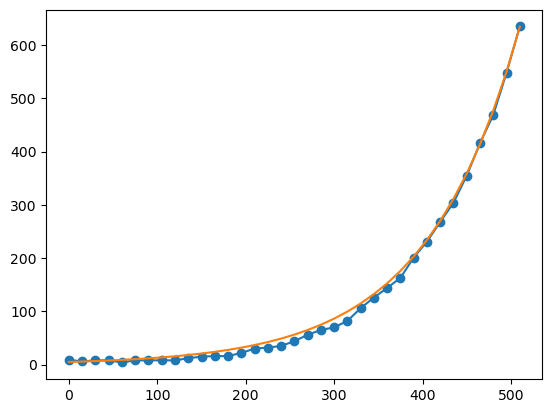

In [11]:
# Bestimme die Wachstumsrate (d.h. die Anzahl der neuen Zellen pro Minute durch
# exponentiellen Fit an die Daten)

with open("C:\\Users\\carol\OneDrive\\Desktop\\Juelich\\maxentflux\\growth_rate_ds.csv", newline='') as csvfile:
    # Erstellen Sie ein CSV-Leserobjekt
    csvreader = pd.read_csv(csvfile)

# Aufteilen der Daten
# Hier: Beispielhaft mit einem Medium
Acetate = csvreader[csvreader['medium'] == 'Acetate-MOPS']
Citrat = csvreader[csvreader['medium'] == 'Citrat-MOPS']
Gluconate = csvreader[csvreader['medium'] == 'Gluconate-MOPS']
PCA = csvreader[csvreader['medium'] == 'PCA-Gluc']
BHI = csvreader[csvreader['medium'] == 'BHI']
Fructose = csvreader[csvreader['medium'] == 'Fructose-MOPS']
Glucose = csvreader[csvreader['medium'] == 'Glucose-MOPS']
Pyruvate = csvreader[csvreader['medium'] == 'Pyruvate-MOPS']
# Daten für Regression
# Wichtig: Muss an das jeweilige Medium angepasst werden!
data = Glucose["cell_count"]
laenge_teilliste = max(Glucose["frame"])
# Daten für die Zeit erstellen
maximaler_wert = (laenge_teilliste + 1) * 15 

t = []

# Schleife, um Vielfache von 15 hinzuzufügen
for i in range(0, maximaler_wert, 15):
    t.append(i)

# Teillisten initialisieren
teillisten = []

# Schleife, um die Ausgangsliste in Teillisten aufzuteilen
def teile_liste(input_list, n):
    # Initialisiere eine leere Ergebnisliste
    output_list = []

    # Schleife, um die Eingabeliste in Teillisten aufzuteilen
    for i in range(0, len(input_list), n):
        teil_liste = input_list[i:i+n]
        output_list.append(teil_liste)

    return output_list

teillisten = teile_liste(data, laenge_teilliste + 1)
        
# Ansatz für die Regression
def exponential_growth(t, r):
    return c * np.exp(r * t)

# Epxonentieller Fit
mw = []

for i in teillisten:        
    c = i.tolist()[0]
    N = i.tolist()
    # Schätze Parameter c und r mit Regression
    params, covariance = curve_fit(exponential_growth, t, N, maxfev = 100000)
    # Extrahieren der geschätzten Parameter
    r_estimated = params
    mw.append(r_estimated)

# \bar{\lambda}
print(np.mean(mw))
bar_lambda = np.mean(mw)
# Varianz der Wachstumsrate
var_lambda = np.var(mw)

# Plotten
y_fit = []
for i in t:
    y_fit.append(5 * np.exp(bar_lambda * i))
plt.plot(t, teillisten[0], marker='o') 
plt.plot(t, y_fit)
plt.show()


2) <br>
Bestimmung des Parameters beta für die Boltzmann-Verteilung<br>
Bei der Normalverteilung sind die Parameter einfach bar_lambda und var_lambda

In [12]:
model_path = os.path.join("C:/Users/carol/OneDrive/Desktop/Juelich", "e_coli_core.xml")

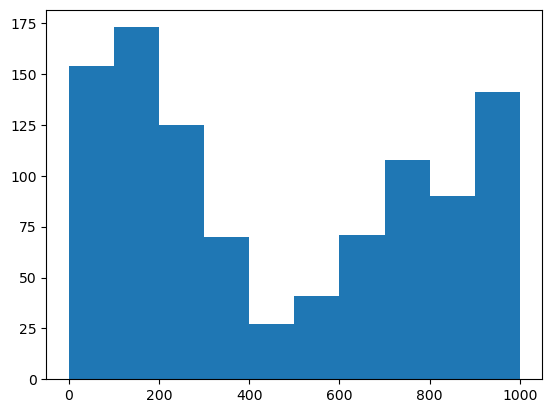

Der gefundene Wert für beta ist: -209.22341022908552


In [14]:
polytope = PolyRoundApi.sbml_to_polytope(model_path)
problem_e_coli = hopsy.Problem(polytope.A, polytope.b)
problem_e_coli = hopsy.round(problem_e_coli)

starting_point = hopsy.compute_chebyshev_center(problem_e_coli)
chains_e_coli = [hopsy.MarkovChain(problem_e_coli, starting_point = starting_point) for i in range(1)]

rng = [hopsy.RandomNumberGenerator(seed= i) for i in range(1)]

accrate_e_coli, samples_e_coli = hopsy.sample(chains_e_coli, rng, n_samples=1000, thinning=10)

# Die Wachstumsrate ist in der 25. Spalte
samples = samples_e_coli[:,:,24][0]
# Histogramm anzeigen lassen
plt.hist(samples)
plt.show()

res_samples = []
# teile die Werte durch 100: funktioniert durch Einheiten-Wechsel
# Ziel: Python kann die Werte wieder ausrechnen
for i in samples:
    res_samples.append(i/100)

# Bestimmung der zu lösenden Gleichung
# Wachstumsrate lambda(v) = v_24 (hier)
def lambda_function(v1, beta):
    res = 0
    res1 = 0
    for i in v1:
        res+= i * np.exp(i*beta)
        res1 += np.exp(i*beta)
    return res/res1 

# Definieren der Funktion, die das Integral berechnet - Abhängig von beta
def quad_integrand(beta):
    result = lambda_function(res_samples, beta)
    return result

# Definieren der Funktion, die integriert wird - Abhängig von beta
def equation_to_solve(beta, c):
    return c - quad_integrand(beta)


# Definiere Konstante c
# Hier die Wachstumsrate von den Zellen in einem bestimmten Medium
# Wichtig ist, dass diese Wachstumsrate grüßer als Null ist
# Kann problematisch werden bei sehr großen oder sehr kleinen Werten!
c =  bar_lambda

# Schätzen Sie einen Startwert für beta
# beta ist (hier) normalerweise negativ
initial_guess = 0

# Verwende fsolve, um die Gleichung zu lösen und den Wert für beta zu finden
result = fsolve(equation_to_solve, initial_guess, args=(c,))

# Das Ergebnis enthält den gefundenen Wert für beta
print(f"Der gefundene Wert für beta ist: {result[0]}")
beta = np.array(result[0])

In [16]:
# negative lok-Likelihood ohne Vorfaktor der Boltzmann-Verteilung
class Boltzman_Modell:
    def __init__(self, beta, index):
        self.beta = beta
        self.index = index
        
    def compute_negative_log_likelihood(self, x):
        return - self.beta * x[self.index]/100

In [15]:
# negative log-likelihood ohne Vorfaktor der Normalverteilung
class Normal_Modell:
    def __init__(self, mu, sigma, index):
        self.mu = mu
        self.index = index
        self.sigma = sigma
        
    def compute_negative_log_likelihood(self, x):
        return 0.5 * (x[self.index]/100-self.mu)**2/(self.sigma**2)

In [17]:
raw_polytope = PolyRoundApi.sbml_to_polytope(model_path)
biomass_index = raw_polytope.A.columns.tolist().index('BIOMASS_Ecoli_core_w_GAM')
glucose_uptake_index = raw_polytope.A.columns.tolist().index('EX_glc__D_e')
polytope = PolyRoundApi.simplify_transform_and_round(raw_polytope)

In [18]:
# Samples sind gleichverteilt
uniform = hopsy.Problem(A=polytope.A, b=polytope.b, transformation=polytope.transformation, shift=polytope.shift)
starting_point = hopsy.compute_chebyshev_center(uniform)

In [39]:
# Für die Boltzmann-Verteilung und Biomasse-Index
a = np.array(result[0])
model_Boltzmann = Boltzman_Modell(a, biomass_index)
uniform_2 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_2 = hopsy.compute_chebyshev_center(uniform_2)

In [38]:
# Für die Boltzmann-Verteilung und Glucose-Index
model_Boltzmann_g = Boltzman_Modell(a, glucose_uptake_index)
uniform_2_g = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann_g, transformation=polytope.transformation, shift=polytope.shift)
starting_point_2_g = hopsy.compute_chebyshev_center(uniform_2_g)

In [40]:
# Für die Normal-Verteilung und Biomasse-Index
mu = np.array(bar_lambda)
sigma = np.array(var_lambda)
model_normal = Normal_Modell(mu, sigma, biomass_index)
normal = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_normal, transformation=polytope.transformation, shift=polytope.shift)
starting_point_normal_3 = hopsy.compute_chebyshev_center(normal)

In [42]:
# Für die Normal-Verteilung und Glucose-Index
model_normal_g = Normal_Modell(mu, sigma, glucose_uptake_index)
normal_g = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_normal_g, transformation=polytope.transformation, shift=polytope.shift)
starting_point_normal_3_g = hopsy.compute_chebyshev_center(normal_g)

In [44]:
problems_g = {
    'uniform': [uniform, starting_point],
    'Boltzmann-Verteilung': [uniform_2_g, starting_point_2_g],  
    #'beta=10': [boltzmann_1, starting_point_boltzmann], 
    # 'beta=-10': [boltzmann_2, starting_point_boltzmann_2], 
     #'beta = -100': [boltzmann_3, starting_point_boltzmann_3],
     'normal':[normal_g, starting_point_normal_3_g]
    }

In [45]:
problems = {
    'uniform': [uniform, starting_point],
    'Boltzmann-Verteilung': [uniform_2, starting_point_2],  
    #'beta=10': [boltzmann_1, starting_point_boltzmann], 
    # 'beta=-10': [boltzmann_2, starting_point_boltzmann_2], 
     #'beta = -100': [boltzmann_3, starting_point_boltzmann_3],
     'normal':[normal, starting_point_normal_3]
    }

In [33]:
rhat = {}
ess = {}
samples = {}
acceptance_rate = {}
n_chains = 4 
n_samples = 10000
thinning = 10

for p, liste in problems.items():
    v = liste[0]
    s = liste[1]
    print(p)
    proposal = hopsy.UniformCoordinateHitAndRunProposal(v, starting_point=s)
    mcs = [hopsy.MarkovChain(problem=v, proposal=proposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(i) for i in range(n_chains)]
    acceptance_rate[p], samples[p] = hopsy.sample(mcs, rngs, n_samples=n_samples, thinning=thinning, n_procs=1)
    ess[p] = hopsy.ess(samples[p])
    print('\tess', np.min(ess[p]))
    rhat[p] = hopsy.rhat(samples[p])
    print('\trhat', np.max(rhat[p]))

uniform
	ess 730.2609014651691
	rhat 1.0066610470050092
Boltzmann-Verteilung
	ess 851.993181498348
	rhat 1.0051786425752114
normal
	ess 4.213845018541751
	rhat 4.527818828720903


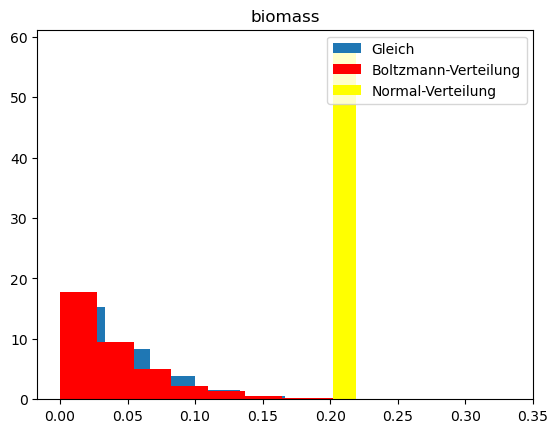

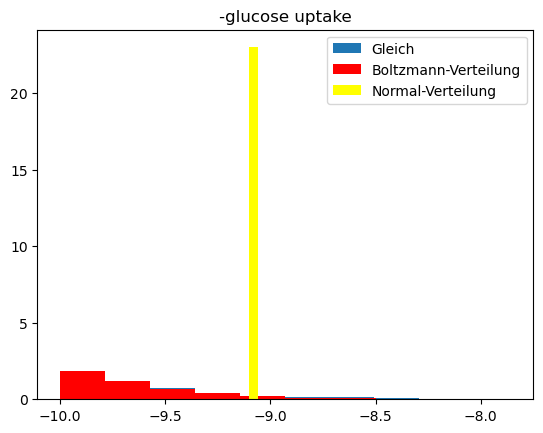

In [37]:
plt.title('biomass')
plt.hist(samples['uniform'][0, :, biomass_index], density = True, label = "Gleich")
plt.hist(samples['Boltzmann-Verteilung'][0, :, biomass_index], density = True, color = "red",label = 'Boltzmann-Verteilung' )
plt.hist(samples['normal'][0, :, biomass_index], density = True, color = "yellow", label = "Normal-Verteilung")
plt.legend(loc='upper right')
plt.show()

plt.title('-glucose uptake')
plt.hist(samples['uniform'][0, :, glucose_uptake_index], density = True, label = "Gleich")
plt.hist(samples['Boltzmann-Verteilung'][0, :, glucose_uptake_index], density = True, color = "red",label = 'Boltzmann-Verteilung')
plt.hist(samples['normal'][0, :, glucose_uptake_index], density = True, color = "yellow", label = "Normal-Verteilung")

plt.legend(loc='upper right')
plt.show()

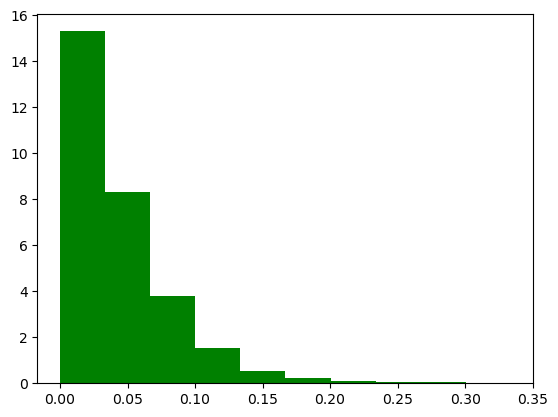

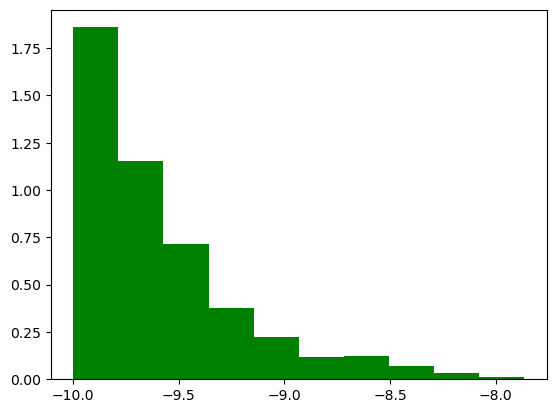

In [27]:
plt.hist(samples['uniform'][0, :, biomass_index], density = True, color = "green", label = "beta = 10")
plt.show()
plt.hist(samples['uniform'][0, :, glucose_uptake_index], density = True, color = "green", label = "beta = 10")
plt.show()

In [46]:
rhat = {}
ess = {}
samples = {}
acceptance_rate = {}
n_chains = 4 
n_samples = 10000
thinning = 10

for p, liste in problems_g.items():
    v = liste[0]
    s = liste[1]
    print(p)
    proposal = hopsy.UniformCoordinateHitAndRunProposal(v, starting_point=s)
    mcs = [hopsy.MarkovChain(problem=v, proposal=proposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(i) for i in range(n_chains)]
    acceptance_rate[p], samples[p] = hopsy.sample(mcs, rngs, n_samples=n_samples, thinning=thinning, n_procs=1)
    ess[p] = hopsy.ess(samples[p])
    print('\tess', np.min(ess[p]))
    rhat[p] = hopsy.rhat(samples[p])
    print('\trhat', np.max(rhat[p]))

uniform
	ess 730.2609014651691
	rhat 1.0066610470050092
Boltzmann-Verteilung
	ess 724.5686648860916
	rhat 1.0058478480686788
normal
	ess 4.215920144670124
	rhat 4.507568481328004


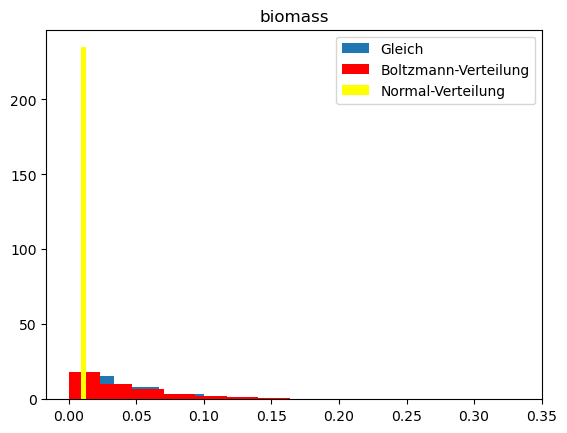

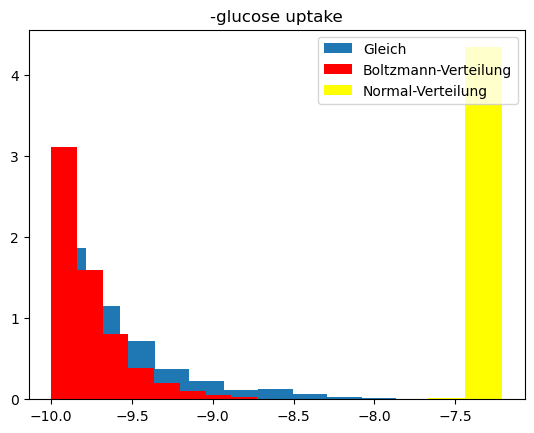

In [47]:
plt.title('biomass')
plt.hist(samples['uniform'][0, :, biomass_index], density = True, label = "Gleich")
plt.hist(samples['Boltzmann-Verteilung'][0, :, biomass_index], density = True, color = "red",label = 'Boltzmann-Verteilung' )
plt.hist(samples['normal'][0, :, biomass_index], density = True, color = "yellow", label = "Normal-Verteilung")
plt.legend(loc='upper right')
plt.show()

plt.title('-glucose uptake')
plt.hist(samples['uniform'][0, :, glucose_uptake_index], density = True, label = "Gleich")
plt.hist(samples['Boltzmann-Verteilung'][0, :, glucose_uptake_index], density = True, color = "red",label = 'Boltzmann-Verteilung')
plt.hist(samples['normal'][0, :, glucose_uptake_index], density = True, color = "yellow", label = "Normal-Verteilung")

plt.legend(loc='upper right')
plt.show()